# Algoritmo genético simple

### Descripción
    
<font size="4"> Algoritmo genético simple de Goldberg para optimización continua (minimización).
 
### Componentes

- <font size="3"> Representación binaria
    
- <font size="3"> Selección proporcional
    
- <font size="3"> Muestreo estocástico con reemplazamiento
    
- <font size="3"> Sustitución generacional completa
    
- <font size="3"> Elitismo
    
- <font size="3"> Cruce uniforme
    
- <font size="3"> Mutación bit-flip
    
 
### Notas de implementación
    
- <font size="3"> La selección proporcional está diseñada para maximización, con $f({\bf x})\geq 0$. Para que el algoritmo sea de minimización se requiere transformar el fitness. En este algoritmo se ha hecho una transformación lineal de la siguiente forma:

    $$f'({\bf x})= C- f({\bf x}) $$

    <font size="3"> donde $C$ es un valor ligeramente superior al máximo valor de $f({\bf x})$ en la población actual:

    $$ C=\max_{{\bf x}\in P}\{f({\bf x})\}+\epsilon$$
        
    
### Comentarios adicionales

- <font size="3"> No hay que ordenar la población.

- <font size="3"> Se requiere calcular el máximo de la población para la transformación lineal.

- <font size="3"> Se requiere calcular el mínimo de la población para el elitismo.
    
- <font size="3"> Presión selectiva alta.

---

### Requerimientos

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import landscapes.single_objective as lso

### Parámetros del algoritmo evolutivo
- $precision$: precisión requerida para las variables de decisión (número de cifras decimales)
- $G$: Número de generaciones
- $N$: Tamaño de la población
- $p\_c$: Probabilidad de cruce
- $p\_m$: Probabilidad de mutación
- $random\_state$: Semilla para reproducibilidad

In [2]:
precision = 6
G = 1000
N = 100
p_c = 0.6
p_m = 0.01
random_state = 1

### Definición del problema de optimización
- $L$: Límite inferior de espacio de búsqueda
- $U$: Límite superior de espacio de búsqueda
- $f$: Función objetivo

In [3]:
def Rastrigin():
    n = 20 # Número de variables de decisión  
    L = np.full(n, -5.12)
    U = np.full(n, 5.12)
    f = lso.rastrigin
    return L,U,f

def Sphere():
    n = 10 # Número de variables de decisión  
    L = np.full(n, -5.12)
    U = np.full(n,  5.12)    
    f = lso.sphere
    return L,U,f

def Rosenbrock():
    n = 5 # Número de variables de decisión  
    L = np.full(n, -2.048)
    U = np.full(n, 2.048)
    f = lso.rosenbrock
    return L,U,f

L,U,f = Rastrigin()
# L,U,f = Sphere()
# L,U,f = Rosenbrock()

### Definición de individuo

In [4]:
class Individuo:
    def __init__(self,n,long):
        self.x = np.zeros(long,dtype='int')
        self.dec = np.zeros(n)
        self.f = 0.0
    def __lt__(self, ind):
        return self.f < ind.f

### Inicialización de la población

In [5]:
def InitializePopulation(P):
    long = P[0].x.size
    for I in P:
        I.x[:] = np.random.randint(0,2,long)

### Decodificación

In [6]:
def decode(I,L,U,longitudes,div_dom):    
    idx = 0 # para recorrer todo el genotipo 
    for i in range(I.dec.size):
        # Representación en base 10
        power = 1
        for _ in range(longitudes[i]):  
            I.dec[i] += I.x[idx]*power
            idx += 1
            power *= 2
    # Cambio de escala    
    I.dec[:] = L+I.dec*(U-L)/div_dom

### Función de evaluación

In [7]:
def evaluate(I,f):           
    I.f = f(I.dec)

### Copia de individuo

In [8]:
def copia(I1, I2):
    np.copyto(I1.x, I2.x)
    I1.f = I2.f   

### Cálculo de las probabilidades acumuladas

In [9]:
def calculate_cumulative_probabilities(cumulative_probabilities,P,N):
    C = max(P).f+1e-6 # Para transformación lineal
    sum_fitness = sum(C-I.f for I in P) # se usa C-f ya que el algoritmo es para minimización
    cumulative_probabilities[0] = (C-P[0].f)/sum_fitness
    for i in range(1,N):
        cumulative_probabilities[i] = cumulative_probabilities[i-1] + (C-P[i].f)/sum_fitness

### Selección proporcional y muestreo estocástico con reemplazamiento (rueda de ruleta)

In [10]:
def selection(P,cumulative_probabilities):
    r = np.random.random()
    i = 0
    while (cumulative_probabilities[i]<r):
        i += 1 
    return P[i]

### Cruce
- Cruce uniforme con probabilidad $p\_c$

In [11]:
def crossover(x1,x2,p_c): 
    if np.random.random()<=p_c:
        for l in range(x1.size):
            if np.random.random()<=0.5:
                x1[l], x2[l] = x2[l], x1[l]         

### Mutación
- Mutación bit-flip con probabilidad $p\_m$

In [12]:
def mutation(x,p_m):
    for l in range(x.size):
        if np.random.random()<=p_m:
            x[l] = 0 if x[l]==1 else 1

### Progreso del algoritmo

In [13]:
def IniciaProgreso(P,G):
    best_outputs = [0]*(G+1) # Para visualizar la gráfica de evolución al final    
    progression_bar = tqdm()
    ActualizaProgreso(P,0,best_outputs,progression_bar)    
    return best_outputs,progression_bar
    
def ActualizaProgreso(P,g,best_outputs,progression_bar):
    best_fitness = min(P).f
    progression_bar.set_description("Processing ... Generation: %s Fitness: %s " % (str(g), str(best_fitness)))
    best_outputs[g] = best_fitness # Añadir mejor fitness (para visualización)
    progression_bar.update(1)

### Algoritmo genético

In [14]:
def EA(G, N, p_c, p_m, f, L, U, precision, random_state):
    
    np.random.seed(random_state)
    
    # Aserciones
    assert G >= 1, "El número de generaciones debe ser mayor o igual que 1."  
    assert N >= 2 and not N % 2, "El tamaño de la población debe ser par y mayor que 1." 
    assert precision >= 0, "La precisión debe ser mayor o igual que 0."  
    
    def AssertProbability(p):
        assert p>=0 and p<=1, "La probabilidad debe estar entre 0 y 1."
    
    AssertProbability(p_c)
    AssertProbability(p_m)
        
    n = L.size # Número de variables de decisión  
    
    # Calcular logitudes de las variables, longitud total del cromosoma y número de divisiones del dominio para el cambio de escala de las variables 
    longitudes = [int(np.ceil(np.log2((U[i]-L[i])*(10**precision)))) for i in range(n) ]        
    long = sum(longitudes)
    div_dom = [2**longitudes[i]-1 for i in range(n)]
    
    cumulative_probabilities = np.zeros(N)
    
    # Crear población inicial con N individuos
    P = [Individuo(n,long) for _ in range(N)]
    InitializePopulation(P)
    
    # Evaluar población inicial
    for I in P:
        decode(I,L,U,longitudes,div_dom)        
        evaluate(I,f)
    
    # Crear población auxilar 
    Q = [Individuo(n,long) for _ in range(N)]
    
    
    # Para Elitismo    
    best_individuo = min(P)
        
    # Evoluciona durante G generaciones
    best_outputs, progression_bar = IniciaProgreso(P,G)    
    for g in range(1,G+1):
        calculate_cumulative_probabilities(cumulative_probabilities,P,N)
        i = 0
        while i < N:
            copia(Q[i],selection(P,cumulative_probabilities))
            copia(Q[i+1],selection(P,cumulative_probabilities))
            crossover(Q[i].x,Q[i+1].x,p_c)
            mutation(Q[i].x,p_m)
            mutation(Q[i+1].x,p_m)
            i += 2 
        copia(P[0],best_individuo)
        for i in range(1,N):            
            copia(P[i],Q[i])
            decode(P[i],L,U,longitudes,div_dom)
            evaluate(P[i],f)
        ActualizaProgreso(P,g,best_outputs,progression_bar)
        best_individuo = min(P)
    return best_outputs, best_individuo.f, best_individuo.dec

### Ejecución del algoritmo genético

In [15]:
%%time
best_outputs, best_fitness, best_solution = EA(G, N, p_c, p_m, f, L, U, precision, random_state)
print("x: ",best_solution)
print("f: ",best_fitness)

Processing ... Generation: 1000 Fitness: 22.035770941442394 : : 1001it [01:10, 14.16it/s]

x:  [-3.74344535  2.52485458  3.17590443 -0.52602512 -4.80242491  2.48601486
 -3.94954949 -4.78901853 -1.14242957  3.65296378 -4.12752619 -4.69843992
  4.2465063   4.11038751 -3.91874077 -1.01873694  2.43018905 -3.87479363
  0.11850434  1.33352578]
f:  22.035770941442394
CPU times: total: 1min 10s
Wall time: 1min 10s


### Visualización de la evolución del algoritmo

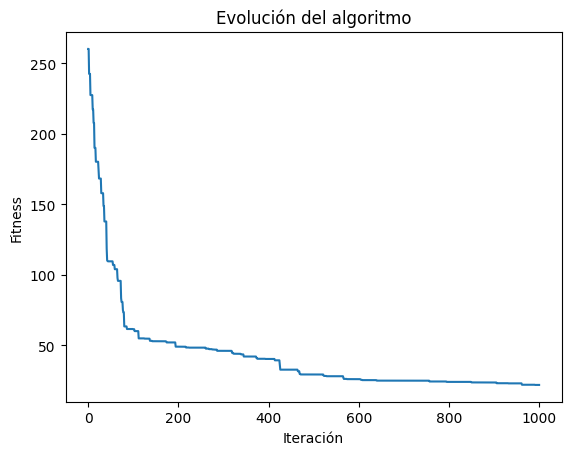

In [16]:
def VisualizaEvolucion(best_outputs):
    fig, ax = plt.subplots()
    ax.set_title("Evolución del algoritmo")
    plt.plot(best_outputs)
    plt.xlabel("Iteración")
    plt.ylabel("Fitness")
    plt.show()

VisualizaEvolucion(best_outputs)